### Introduction

Nous allons travailler sur le jeu de stratégie League of Legends (LoL), dont voici une courte
introduction afin de saisir notre objectif :

Le jeu se compose de deux équipes, les rouges et les bleus, de 5 joueurs chacune. Chaque
partie commence par une phase de sélection (draft) au cours de laquelle chacun des
joueurs choisis parmi plus de 161 champions uniques, celui qu’il va jouer pour la partie. Le
but de chaque équipe est de détruire le cœur de la base ennemi pour gagner la partie et le
choix du champion va déterminer le rôle du joueur dans son équipe.

Les champions deviennent plus forts en accumulant de l'expérience pour monter en niveau
et débloquer de nouveaux sorts, et de l'or pour acheter des objets de plus en plus puissants
au fur et à mesure que le jeu progresse.

Notre objectif est ici d'analyser dans quelle mesure nous pouvons prédire l'issue d'une partie
en nous basant uniquement sur ces données, ainsi que d’autres données des 10 premières
minutes de la partie relatives aux joueurs.

### Librairies

In [1]:
# Utilities
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns

# Data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Evaluation Metrics
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

# Classifiers
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### A propos du Dataset

Notre dataset contient les statistiques des 10 première minutes de jeux d'environ 10 000 parties classés solo (Solo Queue) de partie de haut rang (joueurs du top 1% du classement), où les joueurs ont un niveau relativement homogène.

Chaque partie est unique, identifié par son ID, et rassemble 19 features par équipe (38 au total), décrites çi-dessous :
- blueKills, redKills - Le nombre de champions tués par chaque équipe.
- blueFirstBlood, redFirstBlood - L'équipe qui a tué la première personne.
- blueDeath, redDeath - Le nombre de morts dans chaque équipe.
- blueAssits, redAssits - Les attaques des champion de chaque équipe sur un champion adverse n'étant pas un coup fatal. D'une certaine manière, cette caractéristique représente la collaboration au sein de l'équipe.
- blueAvgLevel, redAvgLevel - Le niveau moyen des champions de chaque équipe
- blueExp, redExp, blueGold, redGold - La quantité d'expérience et d'or gagnée par chaque équipe.
- blueDragons, blueHeralds, blueEliteMonsters, redDragons, redHeralds, redEliteMonsters - Combien de dragons et de hérauts ont été tués par une équipe. Ces nombres peuvent bien prédire les victoires car ce sont des monstres d'élite puissants dans les jeux donnant des avantges le restant de la partie.
- blueTotalMinionsKilled, blueJungleMinionsKilled, redTotalMinionsKilled, redJungleMinionsKilled - Nombre de monstres divers tués.
- blueWardsPlaced, blueWardsDestroyed, redWardsPlaced, redWardsDestroyed - Les Wards sont des balises déployables octroyants différents avantages. Le nombre de wards placés ou de destruites représente donc à quel point une équipe est agressive dans les 10 premières minutes.
- blueTowersDestroyed, redTowersDestroyed - Le nombre de tourelles adverses détruites par chaque équipe. Il s'agit également d'un indice de l'agressivité d'une équipe.
- Caractéristiques comparatives ou agrégées - Des variables telles que la différence de quantité d'or entre les équipes (redGoldDiff) ou encore le nombre de monstres tués par minute (blueCSPerMin).

L'issue de la partie est encapsulée dans l'attribut "blueWins", ayant 1 comme valeur si l'équipe bleu a gagné, et 0 sinon.

Notre intuition serait que les features les plus déterminantes seraient :
- La quantité d'or amassées par chaque équipe, ainsi que la quantité d'expérience
- Le nombre de monste épique tué ainsi que le nombre de tour détruite

Cela réside dans le fait que l'or et l'expérience sont les deux principales monnaies pour augmenter sa puissance et ainsi augmenter ses chances de gagner. L'or permet d'acheter des objets et l'expérience d'améliorer ses capacités. La majorité des actions dans le jeux contribuant à accumuler ces dernières, ces deux valeurs généralent encapsulent une grande quantité d'informations à propos des deux équipes.

Cependant, un retard dans ces métrique d'une équipe peut, au fûr et à mesure que la partie dûr, se combler jusqu'à même possiblement se renverser. Le nombre de monste épique tué ainsi que le nombre de tour détruite traduit alors la capacité de l'équipe ayant actuellement l'avatange à capitaliser sur son avance afin de creuser l'écart d'autant plus et terminer la partie avant que l'équipe adverse ne puisse la rattrapper.

### Exploration du dataset

In [2]:
# Chargement du dataset
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 40)

dataset_path = "Data/high_diamond_ranked_10min.csv"
df = pd.read_csv(dataset_path)
df.sample(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
4482,4524823620,0,51,5,1,8,5,13,0,0,0,0,17663,6.8,18440,202,60,1942,890,20.2,1766.3,39,2,0,5,8,3,1,0,1,0,15721,6.8,17550,205,58,-1942,-890,20.5,1572.1
4748,4523483932,1,15,2,0,9,6,10,0,0,0,0,17118,7.2,19705,224,52,1550,3286,22.4,1711.8,14,3,1,6,9,8,1,1,0,0,15568,6.8,16419,182,56,-1550,-3286,18.2,1556.8
8156,4526999717,0,17,2,0,5,6,8,0,0,0,0,15259,6.6,15471,180,52,-3967,-3114,18.0,1525.9,12,1,1,6,5,8,0,0,0,2,19226,7.0,18585,247,60,3967,3114,24.7,1922.6
4158,4517889362,0,43,2,0,6,5,10,1,1,0,0,15521,6.2,15093,146,42,189,-2888,14.6,1552.1,42,3,1,5,6,1,1,0,1,0,15332,6.8,17981,193,54,-189,2888,19.3,1533.2
486,4518527027,1,41,4,0,7,7,11,1,1,0,0,16787,7.2,18466,201,55,-471,870,20.1,1678.7,39,3,1,7,7,9,0,0,0,0,17258,6.6,17596,229,38,471,-870,22.9,1725.8
4820,4516741439,0,12,2,0,6,7,6,0,0,0,0,16685,6.6,17126,223,44,17,-1180,22.3,1668.5,13,2,1,7,6,4,1,1,0,0,16668,7.0,18306,175,61,-17,1180,17.5,1666.8
8011,4469904395,1,16,0,0,4,7,5,1,1,0,0,15524,7.0,17843,228,56,-629,-209,22.8,1552.4,24,1,1,7,4,7,0,0,0,0,16153,6.8,18052,192,55,629,209,19.2,1615.3
1223,4459704027,1,18,19,1,5,2,7,1,1,0,0,16858,7.2,18543,251,39,2407,939,25.1,1685.8,43,1,0,2,5,3,0,0,0,0,14451,6.6,17604,221,44,-2407,-939,22.1,1445.1
4253,4523031223,1,21,3,1,4,6,5,0,0,0,0,15454,6.8,17256,199,45,-1648,-1354,19.9,1545.4,15,5,0,6,4,3,2,1,1,1,17102,7.0,18610,217,52,1648,1354,21.7,1710.2
220,4512271556,1,13,3,1,11,4,8,2,1,1,1,19377,7.4,20008,233,44,3806,2161,23.3,1937.7,15,0,0,4,11,4,0,0,0,0,15571,7.0,17847,231,44,-3806,-2161,23.1,1557.1


Vérifions qu'il ne manque aucune données

In [3]:
df.isnull().sum().any()

False

Et si les deux classes sont bien équilibrées

In [4]:
df.groupby(by="blueWins").size()

blueWins
0    4949
1    4930
dtype: int64

Regardons de la répartition de chaque feature :

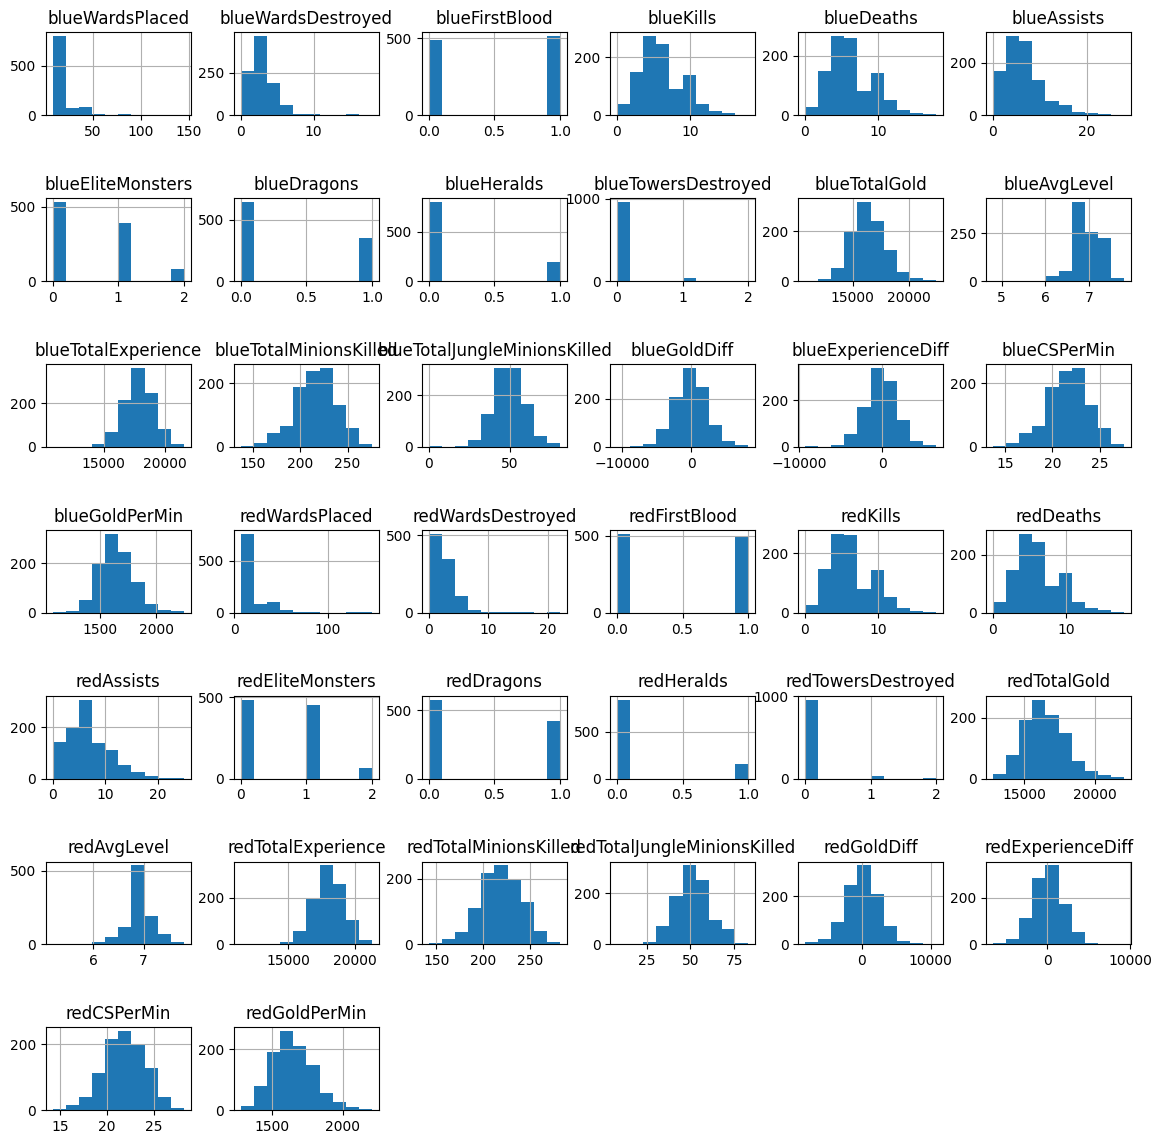

In [5]:
df.iloc[:, 2:].sample(1000).hist(figsize=(14,14))
plt.rcParams["axes.titlesize"] = 5
plt.subplots_adjust(hspace=1)
plt.show()

On observe ici qu'une majorité de features ont une répartition en forme courbe en cloche ce qui nous laisse penser qu'un modèle Bayésien Naïf de Gauss serait un bon choix. Le reste des features sont majoritairement des valeurs binaires.

### Data Preprocessing

A l'aide des histogrames, on remarque qu'il existe quelques features avec une répartition dégénérée.

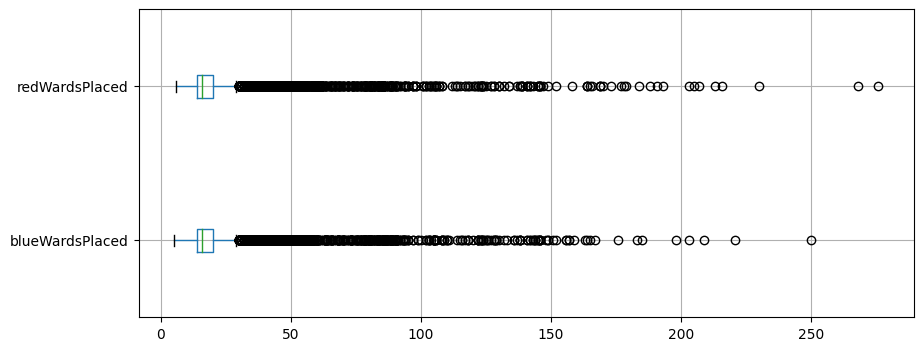

In [6]:
df[["blueWardsPlaced", "redWardsPlaced"]].boxplot(figsize=(10,4), vert=False)
plt.rcParams["axes.titlesize"] = 15
plt.show()

In [7]:
df[["blueWardsPlaced", "redWardsPlaced", "blueWardsDestroyed", "redWardsDestroyed"]].describe()

,blueWardsPlaced,redWardsPlaced,blueWardsDestroyed,redWardsDestroyed
count,9879.000000,9879.000000,9879.000000,9879.000000
mean,22.288288,22.367952,2.824881,2.723150
std,18.019177,18.457427,2.174998,2.138356
min,5.000000,6.000000,0.000000,0.000000
25%,14.000000,14.000000,1.000000,1.000000
50%,16.000000,16.000000,3.000000,2.000000
75%,20.000000,20.000000,4.000000,4.000000
max,250.000000,276.000000,27.000000,24.000000


On voit que pour, par exemple, le nombre de ward, bien que la valeur de Q3 soit de 20, il existe des outliers particulièrement grand allant jusqu'à 250.

Sachant que la médiane est de 16 et en prenant en compte les mécaniques du jeu, il semblerait raisonable d'encoder ces valeurs à l'aide de catégories discrètes, après les avoir regroupé en intervals par quartiles.

In [8]:
# Quantification des quatres features biaisés
df["blueWardsPlaced"] = pd.cut(df["blueWardsPlaced"], bins=[-float("inf"), 14, 16, 20, float("inf")], labels=False)
df["redWardsPlaced"] = pd.cut(df["redWardsPlaced"], bins=[-float("inf"), 14, 16, 20, float("inf")], labels=False)
df["blueWardsDestroyed"] = pd.cut(df["blueWardsDestroyed"], bins=[-float("inf"), 1, 3, 4, float("inf")], labels=False)
df["redWardsDestroyed"] = pd.cut(df["redWardsDestroyed"], bins=[-float("inf"), 1, 3, 4, float("inf")], labels=False)

Elles forment maintenant des catégories equilibrées.

In [9]:
df.groupby(by="blueWardsPlaced").size()

blueWardsPlaced
0    2508
1    2472
2    2590
3    2309
dtype: int64

Penchons nous maintenant sur la matrice de corrélation pour évaluer la redondance qu'il pourrait avoir entre certaines features :

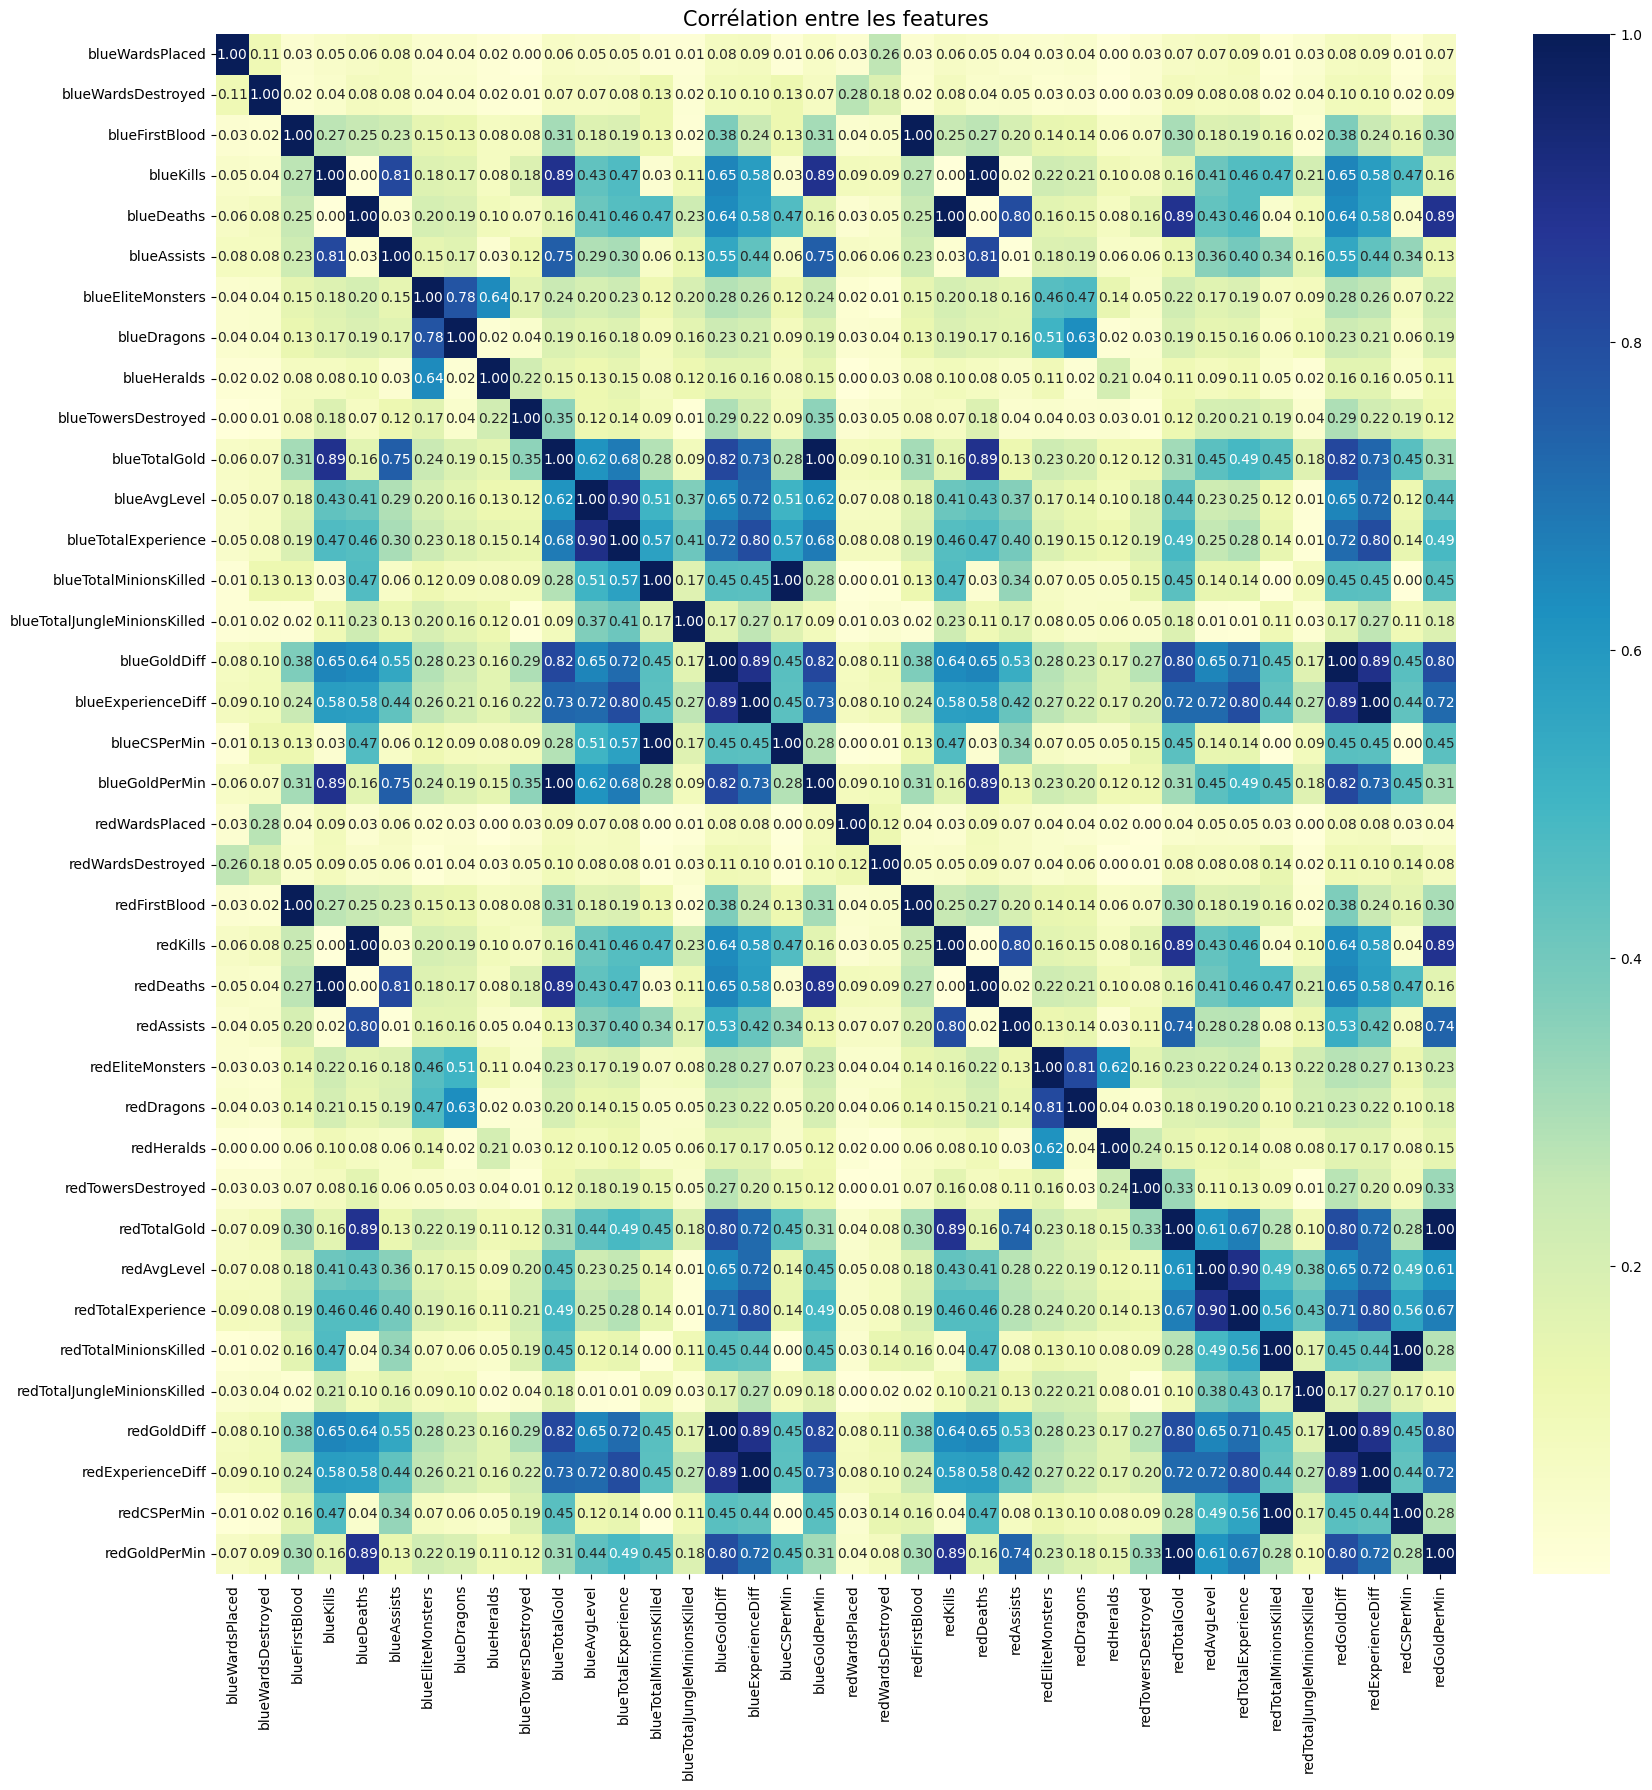

In [10]:
corr = np.abs(df.iloc[:, 2:].corr())
fig, ax = plt.subplots(figsize=(20,20))
plt.rcParams["axes.titlesize"] = 15
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f", ax=ax)
plt.title("Corrélation entre les features")
plt.show()

On remarque que certaines varibales sont des combinaison linéaires d'autres variables, comme pour le nombre de EliteMonsters tué, simplement égal à la somme du nombre de Dragons et d'Heralds tués, tandis que certaines sont directement égales. C'est en effet par exemple le cas pour le nombre de kill effectué par l'équipe Bleu qui est strictement égal au nombre de morts de l'équipe Rouge.

On observe aussi des corrélation élevés entre certaines autres features liées dans le jeu comme entre "redTotalGold" et "blueDeaths" les kill étant une principale source d'or.

Il semble donc pertinent d'éliminer ces features redondantes n'apportants que peu, voir aucune informations supplémentaires.

In [11]:
corr = np.abs(df.iloc[:, 2:].corr())
corr = corr.stack().reset_index()
corr.columns = ["Feature 1", "Feature 2", "Corrélation (abs)"]
# On retire les tuples associé à la diagonale
corr = corr[corr["Feature 1"] != corr["Feature 2"]]
# Puis on retire les couples symétrique appartenant à la partie triangulaire
# inférieur de la matrice
corr["ordered_cols"] = corr.apply(lambda x: "-".join(sorted([x["Feature 1"], x["Feature 2"]])), axis=1)
corr = corr.drop_duplicates(["ordered_cols"])
corr.drop(["ordered_cols"], axis=1, inplace=True)

In [12]:
high_corr = corr[corr["Corrélation (abs)"] >= 0.7].sort_values(by="Corrélation (abs)", ascending=False)
pd.set_option("display.max_rows", None)
high_corr[high_corr['Corrélation (abs)'] == 1]

,Feature 1,Feature 2,Corrélation (abs)
643,blueExperienceDiff,redExperienceDiff,1.0
604,blueGoldDiff,redGoldDiff,1.0
137,blueKills,redDeaths,1.0
174,blueDeaths,redKills,1.0


Les couples de features ayant une corrélation de 1 semblent être en majorité ces couples de valeurs inversés évoqués précedement.

Nous pouvons donc supprimer ces duplicats de la liste des features :

In [13]:
# La liste de toutes les features venant à être supprimées 
features_to_remove = list()
features_to_remove.extend(["redFirstBlood", "redExperienceDiff", "redGoldDiff", "redDeaths", "redKills"])

In [14]:
high_corr[(high_corr["Corrélation (abs)"] >= 0.80) & (high_corr["Corrélation (abs)"] < 1.0)]

,Feature 1,Feature 2,Corrélation (abs)
1252,redTotalMinionsKilled,redCSPerMin,1.000000
1171,redAvgLevel,redTotalExperience,0.901748
430,blueAvgLevel,blueTotalExperience,0.901297
605,blueGoldDiff,redExperienceDiff,0.894729
586,blueGoldDiff,blueExperienceDiff,0.894729
1327,redGoldDiff,redExperienceDiff,0.894729
642,blueExperienceDiff,redGoldDiff,0.894729
124,blueKills,blueTotalGold,0.888751
403,blueTotalGold,redDeaths,0.888751
707,blueGoldPerMin,redDeaths,0.888751


Du reste de cette liste de valeurs ayant une grande corrélation, nous pouvons aussi supprimer celles qui semblent être des combinaisons linéaires d'autres variables. On peut citer, comme précédement, les différences d'or entre les deux équipes (fonctions des quantités d'or totales par équipes), ou bien  la quantité d'or par minute (directement calculés en fonction d'autres comme la quantité de kill totales).

Finalement, la quantité d'expérience totale a été préféré à la moyenne des niveaux des champions, toutes deux étant hautement corrélés, et la première étant plus précise.

In [15]:
features_to_remove.extend(["blueExperienceDiff", "blueGoldPerMin", "redGoldPerMin", "blueGoldDiff", "blueEliteMonsters", "redEliteMonsters", "redAvgLevel", "blueAvgLevel", "blueCSPerMin", "redCSPerMin" ])
df.drop(features_to_remove, axis=1, inplace=True)
df.shape

(9879, 25)

### Prédiction & Performances

Chargement des données.

In [16]:
X = df.drop(["gameId","blueWins"], axis=1).values
y = df["blueWins"].values

Utilisons une PCA pour visualiser nos données avant l'entrainement :

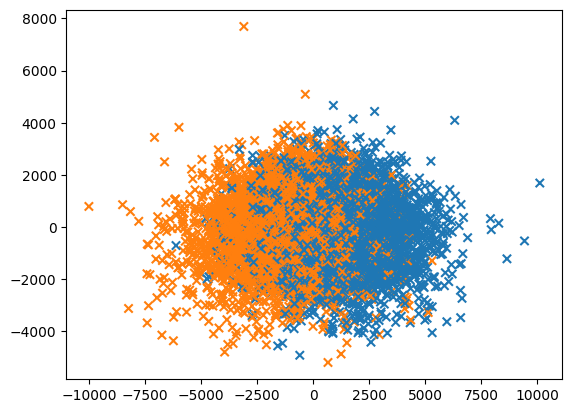

In [17]:
pca = PCA(n_components=2)
pca.fit(X)
transformed_X = pca.transform(X)

mycolorBar = cm.tab10
plt.figure()
plt.scatter(transformed_X[:,0], transformed_X[:,1], c=mycolorBar(y), marker= 'x')
plt.show()

Création des splits pour l'entrainement.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Nous allons utiliser le GaussianNB comme mentionné précedement ainsi que d'autres modèles mentionnés en cours afin, non tuned, de comparer leurs baseline performances :

In [27]:
models = [
  Perceptron(),
  GaussianNB(),
  DecisionTreeClassifier(),
  KNeighborsClassifier(),
  RandomForestClassifier(),
]

In [28]:
for model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    print(f"{str(model).split('(')[0]} train accuracy : {cv_score.mean():.4f} (std {cv_score.std():.4f})")

Perceptron train accuracy : 0.6390 (std 0.1001)
GaussianNB train accuracy : 0.7298 (std 0.0072)
DecisionTreeClassifier train accuracy : 0.6452 (std 0.0146)
KNeighborsClassifier train accuracy : 0.6937 (std 0.0094)
RandomForestClassifier train accuracy : 0.6918 (std 0.0065)


In [29]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
test_result = accuracy_score(y_test, nb_clf.predict(X_test))

print(f"GaussianNB test accuracy : {test_result:.4f}%") 
print(classification_report(y_test, nb_clf.predict(X_test)))

GaussianNB test accuracy : 0.7115%
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1011
           1       0.69      0.73      0.71       965

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



L'accuracy du GaussianNB est d'environ 0.73 sur le test set et 0.71 sur le train set, relativement similaire à la baseline du RandomForestClassifier.

Faisons finalement une seconde PCA afin de vizualiser la limite de décision choisie pas le modèle :

In [22]:
X = StandardScaler().fit_transform(X)

Choix des composantes pour  la PCA.

In [23]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.21515198 0.12192621]


Création du dataframe pour la visualisation et nouvelle PCA dessus.

In [24]:
df_vis = pd.DataFrame(data=components, columns=['pc1', 'pc2'])
df_vis = pd.concat([df_vis, df["blueWins"]], axis=1)
X = df_vis[["pc1", "pc2"]]
y = df_vis["blueWins"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
nb_clf.fit(X_train, y_train)

GaussianNB()

La fonction de visualisation.

In [25]:
def DecisionBoundary(clf):
    X = df_vis[["pc1", "pc2"]]
    y = df_vis["blueWins"]
    
    # La taille du pas entre deux points
    h = 0.02

    # Creation des color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    # Affichage de la limite de décision en attribuant une couleur à
    # chaque point du plan
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Affichage des points utilisés pour l'entrainement
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

Affichage finale :

/home/martin/workspace/projet-ias/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


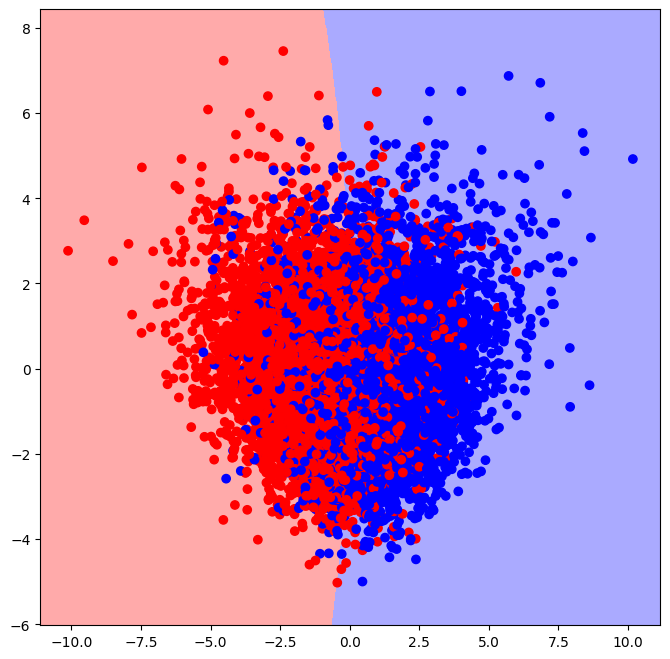

In [26]:
DecisionBoundary(nb_clf)

### Conclusion

Comme prévu, la quantité d'or et d'expérience totale étaient, et de très loins, les deux features ayant  le plus d'impact. Cependant, le nombre de monstres épiques tué n'étant quant à lui, pas du tout aussi prédictif que ce que nous avions prévu.

L'accuracy obtenue est satisfaisante dans la mesure où LoL est un jeu plein de rebondissement, et il paraissait a piori difficile de pouvoir déterminer l'issue d'une partie avec certitude seulement à l'aide des 10 premières minutes de jeu. Cela nous indique donc qu'une équipe, bien qu'elle soit dérrière au début, peut reprendre les devant au cours au milieu de la partie et finalement gagner comme mentionné dans l'introduction.

Malgré cela, les autres modèles n'ayant pas été tuned, nous n'avons que des comparatif de baseline et de part la proximité des résultats du GaussianNB avec ceux du RandomForestClassifier, il n'est pas exclu que nous aurions pu obtenir de legèrement meilleures résultats avec un autre modèle.